# Multi-armed Bandits

We will consider a range of algorithms based on two distinctions:
* what strategy are we using during training: **epsilon-greedy**' or **UCB**
* how do we update estimates: **average** or **step size**

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

class Bandit:
    def __init__(self, k_arm=10, strategy ='epsilon-greedy', update_mode = 'average',
                 epsilon = 0.1, UCB = 0.4, step_size = 0.1, initial = 0):
        # k_arm: number of arms
        self.k = k_arm

        self.time = 0
        self.total_reward = 0

        # First dimension, what strategy are we using during training: 'epsilon-greedy' or 'UCB'
        self.strategy = strategy

        # Second dimension, how do we update estimates: 'average' or 'step_size'
        self.update_mode = update_mode

        # Parameters
        self.epsilon = epsilon
        self.UCB = UCB
        self.step_size = step_size
        self.initial = initial

    def reset(self):
        # reward for each action
        self.q_true = np.random.randn(self.k)
        self.best_action = np.argmax(self.q_true) 

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # number of times each action was chosen
        self.action_count = np.zeros(self.k)

    def choose_action(self):
        # chooses an action
        if self.strategy == 'epsilon-greedy':
            # using the epsilon-greedy strategy
            if np.random.rand() < self.epsilon:
                return np.random.randint(self.k)
            q_best = np.max(self.q_estimation)
            return np.random.choice([action for action, q in enumerate(self.q_estimation) if q == q_best])
        if self.strategy == 'UCB':
            # using the UCB algorithm
            if np.all(self.action_count != 0):
                UCB_estimation = self.q_estimation + self.UCB * np.sqrt(np.log(self.time + 1) / self.action_count)
                q_best = np.max(UCB_estimation)
                return np.random.choice([action for action, q in enumerate(UCB_estimation) if q == q_best])
            else:
                return np.random.choice([action for action in np.arange(self.k) if self.action_count[action] == 0])                

    def update(self, action):
        # play an action and update the estimation for this action
        # generate the reward under using a Gaussian distribution centered around the reward with standard deviation 1
        reward = self.q_true[action] + np.random.randn()
        self.time += 1
        self.total_reward += reward
        self.action_count[action] += 1

        if self.update_mode == 'average':
            # update using sample averages
            self.q_estimation[action] += 1.0 / self.action_count[action] * (reward - self.q_estimation[action])
        if self.update_mode == 'step_size':
            # update with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

The following function simulates **runs** many times a bandit problem for **times** many steps.
Bandits is the list of algorithms to be simulated.

In [2]:
def simulate(runs, time, bandits):
    best_action_counts = np.zeros((len(bandits), runs, time))
    rewards = np.zeros(best_action_counts.shape)
    for i, bandit in enumerate(bandits):
        for r in range(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.choose_action()
                reward = bandit.update(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    best_action_counts = best_action_counts.mean(axis=1)
    rewards = rewards.mean(axis=1)
    return best_action_counts, rewards

This shows how a bandit problem is sampled.

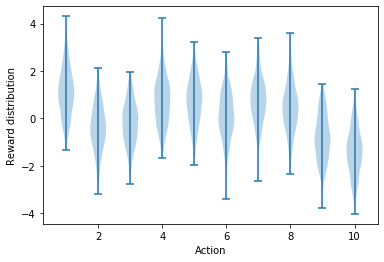

In [3]:
def illustration_rewards():
    plt.violinplot(dataset=np.random.randn(200,10) + np.random.randn(10))
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")
    plt.savefig('1_illustration_rewards.png')
    plt.show()
    plt.close()
    
illustration_rewards()

This shows the influence of the parameter **epsilon** for **epsilon-greedy** strategies.

In [ ]:
def parameter_epsilon(runs=2000, time=1000):
    epsilons = [0, 0.01, 0.1, 0.2]
    bandits = [Bandit(epsilon = eps) for eps in epsilons]
    best_action_counts,rewards = simulate(runs, time, bandits)

    for eps, rewards in zip(epsilons, rewards):
        plt.plot(rewards / time, label='epsilon = %.02f' % (eps))
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()
    plt.savefig('2_epsilon-greedy_average_reward.png')
    plt.show()
    plt.close()

    for eps, counts in zip(epsilons, best_action_counts):
        plt.plot(counts, label='epsilon = %.02f' % (eps))
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.savefig('3_epsilon-greedy_best_actions_count.png')
    plt.show()
    plt.close()

parameter_epsilon()

This shows the influence of the UCB parameter for **UCB** strategies.

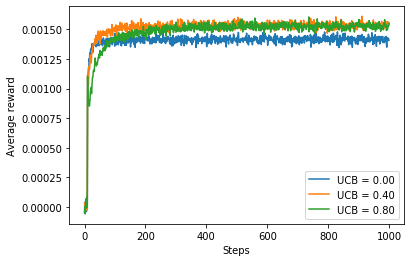

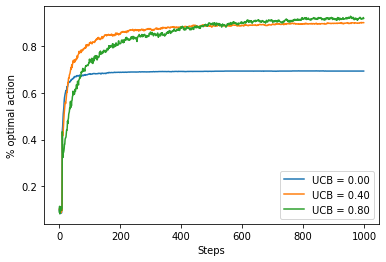

In [5]:
def parameter_UCB(runs=2000, time=1000):
    UCBs = np.arange(0, 1, step = 0.4, dtype=np.float)
    bandits = [Bandit(strategy = 'UCB', UCB = ucb) for ucb in UCBs]
    best_action_counts,rewards = simulate(runs, time, bandits)

    for ucb, rewards in zip(UCBs, rewards):
        plt.plot(rewards / time, label='UCB = %.02f' % (ucb))
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()
    plt.savefig('4_UCB_average_reward.png')
    plt.show()
    plt.close()

    for ucb, counts in zip(UCBs, best_action_counts):
        plt.plot(counts, label='UCB = %.02f' % (ucb))
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.savefig('5_UCB_best_actions_count.png')
    plt.show()
    plt.close()
    
parameter_UCB()

This shows the influence of the **step size** parameter for the **step size** update of the estimates.

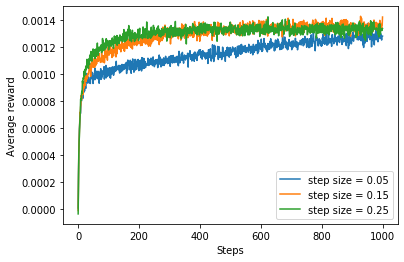

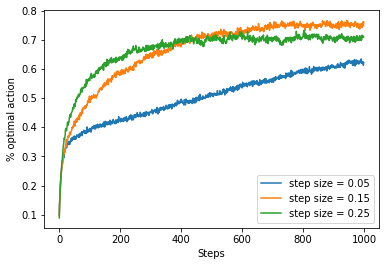

In [6]:
def update_step_size(runs=2000, time=1000):
    step_sizes = np.arange(0.05,0.35, step = 0.1)
    bandits = [Bandit(update_mode = 'step_size', step_size = step_size) for step_size in step_sizes]
    best_action_counts, rewards = simulate(runs, time, bandits)

    for step_size, rewards in zip(step_sizes, rewards):
        plt.plot(rewards / time, label='step size = %.02f' % (step_size))
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()
    plt.savefig('6_step-size-update_average_reward.png')
    plt.show()
    plt.close()

    for step_size, counts in zip(step_sizes, best_action_counts):
        plt.plot(counts, label='step size = %.02f' % (step_size))
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.savefig('7_step-size-update_best_actions_count.png')
    plt.show()
    plt.close()
    
update_step_size()

This shows the influence of optimistic evaluation.

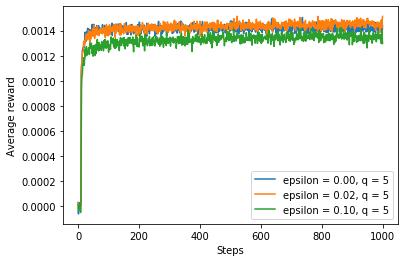

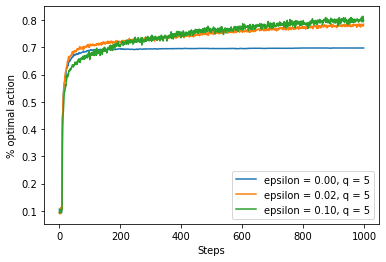

In [7]:
def optimistic_evaluation(runs=2000, time=1000):
    epsilons = [0, 0.02, 0.1]
    bandits = [Bandit(epsilon = eps, initial=5) for eps in epsilons]
    best_action_counts, rewards = simulate(runs, time, bandits)

    for eps, rewards in zip(epsilons, rewards):
        plt.plot(rewards / time, label='epsilon = %.02f, q = 5' % (eps))
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()
    plt.savefig('8_optimistic_evaluation_average_reward.png')
    plt.show()
    plt.close()

    for eps, counts in zip(epsilons, best_action_counts):
        plt.plot(counts, label='epsilon = %.02f, q = 5' % (eps))
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.savefig('9_optimistic_evaluation_best_actions_count.png')
    plt.show()
    plt.close()
    
optimistic_evaluation()

This is a comparison of two algorithms: UCB and epsilon-greedy (with best parameters).

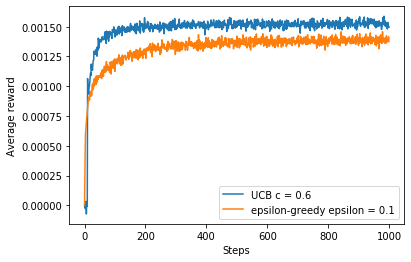

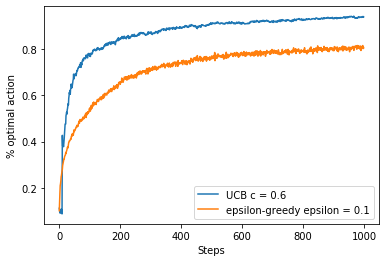

In [8]:
def comparison_UCB_epsilon_greedy(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(strategy = 'UCB', UCB=0.6))
    bandits.append(Bandit(strategy = 'epsilon-greedy', epsilon=0.1))
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.plot(rewards[0] / time, label='UCB c = 0.6')
    plt.plot(rewards[1] / time, label='epsilon-greedy epsilon = 0.1')
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()

    plt.savefig('10_comparison_UCB_epsilon-greedy_average_reward.png')
    plt.show()
    plt.close()

    plt.plot(best_action_counts[0], label='UCB c = 0.6')
    plt.plot(best_action_counts[1], label='epsilon-greedy epsilon = 0.1')
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    
    plt.savefig('11_comparison_UCB_epsilon-greedy_best_action.png')
    plt.show()
    plt.close()
    
comparison_UCB_epsilon_greedy()